<small><i>
This notebook is part of <a href="http://opensmfs.github.io/PyBroMo" target="_blank">PyBroMo</a> a 
python-based single-molecule Brownian motion diffusion simulator 
that simulates confocal smFRET
experiments.
</i></small>

## *Overview*

*In this notebook we show how to perform a 3-D trajectories simulation of a set of freely diffusing molecules. The simulation computes (and saves!) 3-D trajectories and emission rates due to a confocal excitation PSF for each single molecule. Depending on the simulation length, the required disk space can be significant (~ 750MB per minute of simulated diffusion).*

*For more info see [PyBroMo Homepage](http://opensmfs.github.io/PyBroMo/)*.

## Simulation setup

Together with a few standard python libraries we import **PyBroMo** using the short name `pbm`. 
All **PyBroMo** functions will be available as `pbm.`*something*.

In [1]:
import numpy as np
import tables
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install pybromo
!pip install PyQt5
import pybromo as pbm

In [3]:
print('Numpy version:', np.__version__)
print('PyTables version:', tables.__version__)
print('PyBroMo version:', pbm.__version__)

Numpy version: 1.19.5
PyTables version: 3.4.4
PyBroMo version: 0.8.1


In [4]:
%matplotlib inline
plt.style.use('seaborn-poster')

Then we define the simulation parameters:

In [5]:
# Initialize the random state
rs = np.random.RandomState(seed=1)
print('Initial random state:', pbm.hashfunc(rs.get_state()))

# Simulation time step (seconds)
t_step = 0.5e-6

# Time duration of the simulation (seconds)
t_max = 1

# Diffusion coefficient
Du = 12.0            # um^2 / s
D1 = Du*(1e-6)**2    # m^2 / s
D2 = D1/2

# Simulation box definition
box = pbm.Box(x1=-4.e-6, x2=4.e-6, y1=-4.e-6, y2=4.e-6, z1=-6e-6, z2=6e-6)

# Particles definition
P = pbm.Particles.from_specs(
    num_particles=(3, 1),
    D=(D1, D2),
    box=box, rs=rs)

# PSF definition
psf = pbm.NumericPSF()
#psf = pbm.GaussianPSF(sx=0.2e-6, sy=0.2e-6, sz=0.8e-6)

# Particle simulation definition
S = pbm.ParticlesSimulation(t_step=t_step, t_max=t_max, 
                            particles=P, box=box, psf=psf)

print('Current random state:', pbm.hashfunc(rs.get_state()))

Initial random state: bfb867eb5c5858e04685b790d6370c458b9747d6
Current random state: ebb3a449a85a4547d8b2b17f387ee062c9a35abc


The most important line is the last line which creates an object `S` 
that contains all the simulation parameters (it also contains methods to run 
the simulation). You can print `S` and check the current parameters:

## Brownian motion simulation

In the brownian motion simulation we keep using the same random state object `rs`. 
Initial and final state are saved so the same simulation can be reproduced. 
See [PyBroMo - A1. Reference - Data format and internals.ipynb](PyBroMo - A1. Reference - Data format and internals.ipynb) 
for more info on the random state.

In [6]:
print('Current random state:', pbm.hashfunc(rs.get_state()))

Current random state: ebb3a449a85a4547d8b2b17f387ee062c9a35abc


In [7]:
S.simulate_diffusion(total_emission=False, save_pos=True, verbose=True, 
                     rs=rs, chunksize=2**19, chunkslice='times')

- Start trajectories simulation - Thu Feb 11 21:18:40 2021
[PID 262] Diffusion time: 1s
- End trajectories simulation - Thu Feb 11 21:18:44 2021


In [8]:
print('Current random state:', pbm.hashfunc(rs.get_state()))

Current random state: ef6cb90987c38d0982b95d9f76a14c990ad5461e


In [9]:
S.store.close()

# Load trajectories

In [10]:
S = pbm.ParticlesSimulation.from_datafile(S.hash()[:4])  # Read-only by default

 - Found matching timestamps.


In [11]:
S.psf_pytables.attrs

/psf/default_psf._v_attrs (AttributeSet), 9 attributes:
   [CLASS := 'ARRAY',
    FLAVOR := 'numpy',
    TITLE := 'PSF x-z slice (PSFLab array)',
    VERSION := '2.4',
    dir_ := '/usr/local/lib/python3.6/dist-packages/pybromo/psf_data',
    fname := 'xz_realistic_z50_150_160_580nm_n1335_HR2',
    kind := 'numeric',
    x_step := 0.0625,
    z_step := 0.0625]

In [12]:
if hasattr(S, 'ts_store'):
    S.ts_store.close()  # needed if timestamp file is already present

# Low-level timestamp simulation

Here we simulate some timestamps array one by one. To generate smFRET data in one step (donor + acceptor, single or multiple populations and create [Photon-HDF5](http://photon-hdf5.org) files see the next notebook:

- [PyBroMo - 2. Generate smFRET data, including mixtures](PyBroMo - 2. Generate smFRET data, including mixtures.ipynb)

In [13]:
S.compact_name()

'8c4e26_P3_D1.2e-11_P1_D6e-12_8pM_step0.5us_t_max1.0s_ID0-0'

In [14]:
code = S.compact_name()[:4]
code

'8c4e'

In [15]:
S = pbm.ParticlesSimulation.from_datafile(code, mode='w')

 - Found matching timestamps.


Simulate timestamps treating all particles as a single population with same max 
brightness (particles may still have different diffusion coefficient though):

In [16]:
ts_params1 = dict(
    max_rates=(200e3,), 
    populations=(slice(0, 3),),
    bg_rate=1e3,
    )

S.simulate_timestamps_mix(save_pos=True, overwrite=True, **ts_params1)
S.simulate_timestamps_mix(save_pos=False, overwrite=True, **ts_params1)
S.simulate_timestamps_mix(save_pos=False, overwrite=True, **ts_params1)


INFO: Random state initialized from seed (1).
 1.0sINFO: Random state set to last saved state in 'timestamps'.
 1.0sINFO: Random state set to last saved state in 'timestamps'.
 1.0s

Simulate timestamps giving different brightness to each populations:

In [17]:
ts_params2 = dict(
    max_rates=(250e3, 180e3), 
    populations=(slice(0,3), slice(3, 3+1)),
    bg_rate=1.2e3
)

S.simulate_timestamps_mix(save_pos=True, overwrite=True, **ts_params2)

INFO: Random state set to last saved state in 'timestamps'.
 1.0s

To get the timestamps and particles (pytables) arrays, we need to find the name first:

In [18]:
S.timestamp_names

['Pop1_P3_Pstart0_max_rate200000cps_BG1000cps_t_1s_rs_313a05',
 'Pop1_P3_Pstart0_max_rate200000cps_BG1000cps_t_1s_rs_bfb867',
 'Pop1_P3_Pstart0_max_rate200000cps_BG1000cps_t_1s_rs_d29b5f',
 'Pop1_P3_Pstart0_max_rate250000cps_BG1200cps_Pop2_P1_Pstart3_max_rate180000cps_BG1200cps_t_1s_rs_cfdce8']

Picking the last of the names above:

In [19]:
ts, part, pos = S.get_timestamp_data(S.timestamp_names[-1])

In [20]:
ts, part, pos

(/timestamps/Pop1_P3_Pstart0_max_rate250000cps_BG1200cps_Pop2_P1_Pstart3_max_rate180000cps_BG1200cps_t_1s_rs_cfdce8 (EArray(1416,), shuffle, blosc(5)) 'Simulated photon timestamps'
   atom := Int64Atom(shape=(), dflt=0)
   maindim := 0
   flavor := 'numpy'
   byteorder := 'little'
   chunkshape := (65536,),
 /timestamps/Pop1_P3_Pstart0_max_rate250000cps_BG1200cps_Pop2_P1_Pstart3_max_rate180000cps_BG1200cps_t_1s_rs_cfdce8_par (EArray(1416,), shuffle, blosc(5)) 'Particle number for each timestamp'
   atom := UInt8Atom(shape=(), dflt=0)
   maindim := 0
   flavor := 'numpy'
   byteorder := 'irrelevant'
   chunkshape := (65536,),
 /timestamps/Pop1_P3_Pstart0_max_rate250000cps_BG1200cps_Pop2_P1_Pstart3_max_rate180000cps_BG1200cps_t_1s_rs_cfdce8_pos (EArray(1416, 3), shuffle, blosc(5)) 'Particle position for each timestamp'
   atom := Float32Atom(shape=(), dflt=0.0)
   maindim := 0
   flavor := 'numpy'
   byteorder := 'little'
   chunkshape := (65536, 3))

To get the data in memory as a numpy array use `[:]`:

In [21]:
ts[:].shape

(1416,)

# plot cumulative distribution of timestamp

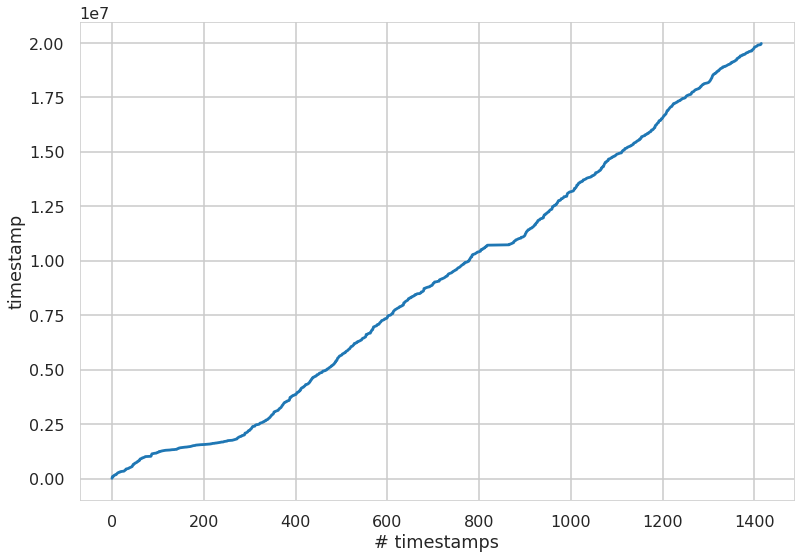

In [22]:
plt.plot(ts)
plt.xlabel('# timestamps')
plt.ylabel('timestamp');

# plot number of photons as a function time

In [23]:
# generate an array of Poisson random variables 
size = ts[:].shape # experimental acquisition time in seconds
lam = 25 # average number of photons 
offset = lam

# number of photons counted, offset for plotting about 0
d = np.random.poisson(lam = lam, size = size) 
d.shape

(1416,)

In [24]:
snr = np.sqrt(lam)
error = snr + d
conf = lam+snr + lam-snr 
conf

50.0

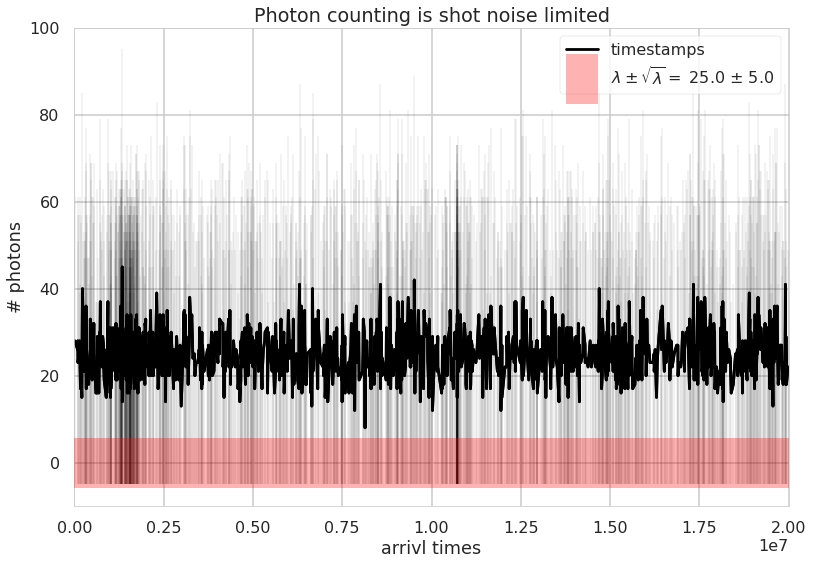

In [27]:
plt.errorbar(x=ts, y=d, yerr=error, color = 'k', elinewidth=0.1, zorder = 1)
plt.plot(ts, d, color = 'k', zorder = 2, label = 'timestamps')
plt.hlines(0, xmin=0, xmax=2e7, color = 'r', linewidth = conf, alpha = 0.3, zorder = 3, label = '$\lambda \pm \sqrt{\lambda} =$' + f'{lam: .1f} $\pm$ {snr}')
plt.xlim(0, 2e7)
plt.xlabel('arrival times')
plt.ylabel('# photons')
plt.title(f'Photon counting is shot noise limited')
plt.legend();
